# Visualizing Price Changes a la Reis (2006)

**Richard Shu**

This project will graphically demonstrate how price adjustments occur in an economy where producers have an imperfect picture of the economy. This model is in many ways more realistic than traditional economic models of price-setting, wherein producers are perfectly cognizant of the state of the world at all stages and are able to optimize with respect to that state. But in the real world, gathering information about the economy can be difficult and costly. This model of price-setting, as described by Reis's paper "Inattentive Producers," assumes that agents are entirely ignorant of the state of the world until they pay a fixed cost. At that point, the agent knows the state of the current period and all periods in the past. The important question then becomes when it is right for an agent to update, and what the prices will look like as a result.

Most of my findings will be adapted from Laura Veldkamp's textbook "Information Choice in Macroeconomics and Finance," where she presents a stripped-down version of the Reis model.

In [102]:
import numpy.random as rand
import matplotlib.pyplot as plt
import pandas as pd
import sys

%matplotlib inline                     

print('Python version: ', sys.version)
print('Pandas version: ', pd.__version__)

plt.style.use('seaborn-dark-palette')

Python version:  3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.18.0


The model depicts an economy with multiple periods and an infinite number of producers, all of whom are trying to set prices as close as possible to some target price. This target price is given by a linear combination of demand and average price:

p(t) = (1-r) \* m(t) + r *p_avg(t)

Determining this target price is thus contingent on both demand and average price. Demand is modeled as a random walk, with each period receiving a normally-distributed natural-log demand 'shock' epsilon. The code below models this demand structure.

In [103]:
variance = .25 #sets variance of epsilon
pds = 100 #sets number of periods
r = .7 #sets relative weight of average price on target price

shocklist = []
cumulist = []
dum_variable = 0
for numba in range(pds):
    e = rand.normal(loc = 0.0, scale = variance, size = None) 
    #each log epsilon shock is a normally distributed random variable centered at 0
    shocklist.append(e)
for elem in shocklist:
    dum_variable += elem
    #This accumulates every epsilon leading up to the period 
    #makes up the random walk
    cumulist.append(dum_variable)
demand = pd.DataFrame({'Period shocks': shocklist, 'Cumulative demand': cumulist})

In [104]:
demand.head()

,Cumulative demand,Period shocks
0,-0.399466,-0.399466
1,-0.501537,-0.102071
2,-0.734734,-0.233197
3,-0.506725,0.228009
4,-0.256434,0.250291


What we have now is a pandas dataframe containing the randomly-generated demand shocks and the demand, which is the result of the accumulation of those shocks in each period. Every time the cell is run, a new demand series will be generated.

The path of demand can be seen below:

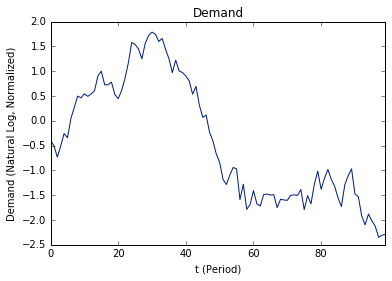

In [105]:
fig, ax = plt.subplots()
ax.set_title('Demand')
ax.set_xlabel('t (Period)')
ax.set_ylabel('Demand (Natural Log, Normalized)')
demand['Cumulative demand'].plot(kind = 'line',
                                 ax = ax,
                                 legend = False,)

The next step is to model the target price, which can be quite nasty. 

The crux of the Reis model is the idea of inattention. Producers have a very specific, and very limited information set -- unlike traditional economics which presumes that agents are perfectly cognizant of the state of the world. Instead, Reis incorporates an information constraint known as "inattention". Every period, each agent has the option to pay a fixed cost c to learn everything about demand from that period backwards. This cost disincentivizes firms from just updating every period -- sometimes they'll just determine that it's not worth it. 

But when they do pay, they don't learn anything else until they pay again. This means that at any given time, only a certain fraction of the producers are totally up-to-date on the demand. 

In addition, no one can directly observe average prices of the period. However, as Reis works out, with common knowledge producers can derive the average price from observing the updating pattern of the other producers.

One of the infinitely many equilibria that can arise from this game is that no one updates until a fixed point T. At T, everyone updates. Every period after, some fraction 1/T of the producers update their information. The critical value from this behavior is L(t, tau), which is the fraction of producers who have updated their information from tau to t. In this case, it can be given as the following: 

In [106]:
T = 10 #can adjust this

def L(t, tau):
    if t >= T: 
        if tau <= T: lam = 1
        else: lam = (1-(1-T**-1)**(t-tau)) #derived from each period's update proportion being independent
    else: lam = 0
    return lam 

With the pattern of updating in the macroeconomy thus defined, we can evaluate the value of average price, which at each period is a weighted accumulation of the epsilon shocks. Each period's shock is weighed both by how important coordination is in the target price (value of r) and how many other people are up to date on demand (L), the idea being that one period's shock may not matter that much if, during that period, not many other people are aware of it. 

In [107]:
def eps(t): #finds the float value of the period t shock
    return float(demand['Period shocks'][demand.index == t])

def p_avg(t): #average price
    return sum([((L(t,s)*(1-r))/(1-(r*L(t,s))))*eps(s) for s in range(t)])    
#formula for average price was outlined in Veldkamp (2014)
demand['Average price'] = [p_avg(t) for t in range(pds)]

We can thus define target price as above.

In [108]:
def p_target(t):
    m = float(demand['Cumulative demand'][demand.index == t])
    tar = (1-r)*m + r*p_avg(t)
    #p_target as defined in the original problem; linear combination of demand and p_avg
    return tar

In [109]:
demand['Target price'] = [p_target(t) for t in range(pds)]
#Now the table for demand has four columns:
#Cumulative demand, period shocks, average prices, target prices

In [110]:
demand.head(2 * T)

,Cumulative demand,Period shocks,Average price,Target price
0,-0.399466,-0.399466,0.000000,-0.119840
1,-0.501537,-0.102071,0.000000,-0.150461
2,-0.734734,-0.233197,0.000000,-0.220420
3,-0.506725,0.228009,0.000000,-0.152018
4,-0.256434,0.250291,0.000000,-0.076930
5,-0.341528,-0.085094,0.000000,-0.102459
6,0.043829,0.385357,0.000000,0.013149
7,0.266625,0.222796,0.000000,0.079988
8,0.497813,0.231187,0.000000,0.149344
9,0.462572,-0.035241,0.000000,0.138772


But tables can only tell us so much. Graphs are much more revealing. 

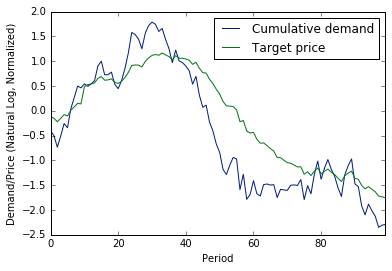

In [111]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Period')
ax1.set_ylabel('Demand/Price (Natural Log, Normalized)')

demand[["Cumulative demand", "Target price"]].plot(kind = 'line', ax = ax1)

The shocks to cumulative demand are reflected in the variations of target price, but much less extremely, as would be expected from the formula for target price which weighs cumulative demand less than fully. 

Important to note is that around period T, target price jumps sharply to meet cumulative demand. This is because average price does not budge from the baseline of 0 until people start updating their information: up until T, L(t, tau) == 0, so each epsilon shock is weighted 0. This can be more easily observed in the graph below.

Average price is a bit more interesting. Not only does it make up the target price, but it also chases the target price. This results in an average price that shows similar patterns to target price, but more smoothly and with a noticeable lag.

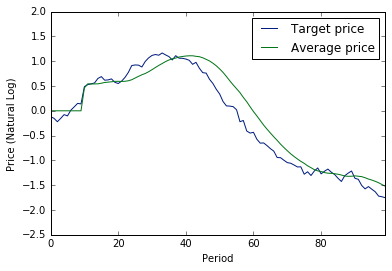

In [112]:
fig2, ax2 = plt.subplots()
ax2.set_xlabel('Period')
ax2.set_ylabel('Price (Natural Log)')
ax2.set_ylim(ax1.get_ylim())

demand[["Target price", "Average price"]].plot(kind = 'line', ax = ax2)

It is this lag that ultimately makes up the most important result of Reis. It demonstrates that, in this economy, firms do not respond elastically to changes in demand -- a lot of the time it's better to just go with the flow. And, in the real world, a lot of the time this is the case. The average supermarket, for example, isn't looking so much at factors in the macroeconomy when setting prices, it's looking more at the prices of their competitor down the street. Those macro factors do play in, but in a muted way, and only after other people in the economy have started to get wind of them.

The second part of Reis's analysis is the behavior of an individual firm in the economy -- specifically, which points they decide to update their prices. Since updating takes a certain cost, he reasons, it must be that for a firm to update prices, they must be able to figure out that their expected loss from remaining ignorant must exceed the immediate cost of updating, which is fixed.

In [113]:
c = .5

The formula for expected loss -- that is, the possible disutility that one could get from not updating between tau_hat and t, is given by the following:

In [114]:
def Loss(t, tau_hat):
    sm = 0
    for k in range(tau_hat + 1, t):
        sm += (1-r)/(1-(r*L(t, k)))
    return sm * variance
loss_list = [Loss(t, T) for t in range(pds)]

Whenever the agent updates, tau_hat resets to that period, and Loss for that period becomes 0 minus the cost c. 
However, every time the agent updates, that tau_hat is increased and the loss function is reset. So for a rationally updating agent, Loss will never exceed cost c. 

With the loss function and cost defined, we can determine when the agent decides to update -- that is, whenever the Loss function creeps up to c. Keep in mind, however, that every time the agent updates, that tau_hat changes, and the Loss function resets. 

In [115]:
loss_list1 = loss_list.copy()
update_pds = []
for x in range(pds):
    if x == T:
        tau_hat = x #predetermined point at which everyone updates
        update_pds.append(x)
    elif loss_list1[x] > c:
        tau_hat = x #x becomes the new "last period updated"
        update_pds.append(x)
        loss_list1[x] = 0.0
        for s in range(x+1, pds): #all future periods are affected by this new tau_hat
            loss_list1[s] = Loss(s, tau_hat)
update_check = []            
for x in range(pds):
    if x in update_pds: update_check.append("Yes")
    else: update_check.append("No") 
        
demand['Update?'] = update_check

In [116]:
demand.tail(10)

,Cumulative demand,Period shocks,Average price,Target price,Update?
90,-1.474313,-0.504943,-1.311549,-1.360379,No
91,-1.528274,-0.053961,-1.319096,-1.381849,No
92,-1.918498,-0.390224,-1.327882,-1.505067,No
93,-2.097688,-0.179191,-1.348928,-1.573556,No
94,-1.881274,0.216414,-1.375988,-1.527574,Yes
95,-2.013247,-0.131973,-1.396535,-1.581549,No
96,-2.124418,-0.111171,-1.421511,-1.632383,No
97,-2.348634,-0.224217,-1.450376,-1.719853,No
98,-2.306600,0.042034,-1.486845,-1.732772,No
99,-2.290446,0.016154,-1.522507,-1.752889,No


With these updates cemented, we can determine what the agent's price is at that given time -- they just set it to the target price, which they can derive due to their observation of demand. Once they update, however, they don't change their target price at all. After all, without information, their expectation of epsilon, the change in demand each period, is 0. 

In [117]:
agent_price = []
curr_price = 0
for t in range(pds):
    if update_check[t] == "Yes": 
        agent_price.append(p_target(t))
        curr_price = p_target(t)
    else: agent_price.append(curr_price)
demand["Agent price"] = agent_price

In [118]:
demand.tail(10)

,Cumulative demand,Period shocks,Average price,Target price,Update?,Agent price
90,-1.474313,-0.504943,-1.311549,-1.360379,No,-1.308100
91,-1.528274,-0.053961,-1.319096,-1.381849,No,-1.308100
92,-1.918498,-0.390224,-1.327882,-1.505067,No,-1.308100
93,-2.097688,-0.179191,-1.348928,-1.573556,No,-1.308100
94,-1.881274,0.216414,-1.375988,-1.527574,Yes,-1.527574
95,-2.013247,-0.131973,-1.396535,-1.581549,No,-1.527574
96,-2.124418,-0.111171,-1.421511,-1.632383,No,-1.527574
97,-2.348634,-0.224217,-1.450376,-1.719853,No,-1.527574
98,-2.306600,0.042034,-1.486845,-1.732772,No,-1.527574
99,-2.290446,0.016154,-1.522507,-1.752889,No,-1.527574


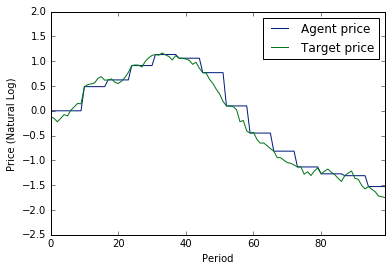

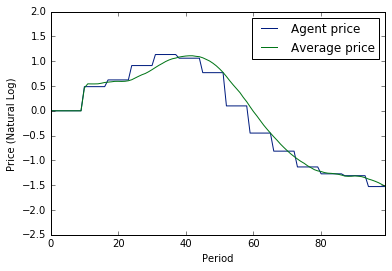

In [119]:
fig4, ax4 = plt.subplots()
ax4.set_xlabel('Period')
ax4.set_ylabel('Price (Natural Log)')
ax4.set_ylim(ax1.get_ylim())

fig3, ax3 = plt.subplots()
ax3.set_xlabel('Period')
ax3.set_ylabel('Price (Natural Log)')
ax3.set_ylim(ax1.get_ylim())

demand[["Agent price", "Target price"]].plot(kind = 'line', ax = ax4)
demand[["Agent price", "Average price"]].plot(kind = 'line', ax = ax3)

You can hit "Run All" to see a new demand walk and the new results that emerge.

**Conclusion**

Reis provides a compelling model because it accurately reflects many of the market conditions that are most relevant to producers on a small level. Inattention is an attractive model because, in many ways, it reflects an organization's approach to learning. That is, a human may be passively observing the world around them all the time, but for an organization like a firm to collect information requires sophisticated, thorough and costly actions. It is an active decision for a firm to conduct research. 

That said, I did somewhat gloss over the way that lambda -- that is, the updating pattern of the macroeconomy -- was decided. I specified one equilibrium updating pattern, but in truth there are infinitely many, and as far as my understanding goes there is not one that necessarily emerges from the updating pattern of individuals. In other words, the simplified model does not bridge the macro-micro gap fully. It treats the macroeconomy as somewhat exogenous when determining how the micro agent behaves. For example, it may well be that, in a more realistic model, there would be some producers who don't update in a rational way and whose irrational updating schedule prompts the rest of the economy to chase. 